# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [178]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import skimage.io
import random
import skimage.transform
from PIL import Image

# Helper functions

In [139]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)


def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [207]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>

    idx1 = np.where(dist < num_matches)[0]
    idx2 = np.where(dist < num_matches)[1]
#     c1 = np.array([kp1[idx].pt for idx in idx1])
#     c2 = np.array([kp2[idx].pt for idx in idx2])

#     idx_all = np.where(dist < num_matches)[0]
    c1 = []
    c2 = []
    for idx in idx1:
        c1.append(kp1[idx].pt)
    c1 = np.array(c1)
    
    for idx in idx2:
        c2.append(kp2[idx].pt)
    c2 = np.array(c2)

    # put into pairs of coords
    if len(c1) == 0 and len(c2) == 0:
        print("num_matches is too small")
        return []
    best_matches = np.concatenate((c1, c2), axis=1)

    return best_matches

In [208]:
def ransac(img1, img2, matches, thres_ransac):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    itertimes = 1000
    inliners = 0
    max_inliners = 0

    for iter in range(0, itertimes):
        subset_idx = random.sample(range(matches.shape[0]), k=4)
        subset = matches[subset_idx]

        H = compute_homography(subset)

        # check if it is full rank
        if np.linalg.matrix_rank(H) < 3:
            continue

        # the norm of error caused if we choose the above subset
        errors = get_errors(matches, H)
        idx = np.where(errors < thres_ransac)[0]
        inlinerspts = matches[idx]

        # find the best number of inliners 
        inliners = len(inlinerspts)
        if inliners >= max_inliners:
            which_inliners = inlinerspts.copy()
            max_inliners = inliners
            best_H = H.copy()
            
            avg_residual = sum(get_errors(matches[idx], H)) / inliners

    print("num of inliners: " + str(max_inliners) + " average residual: " + str(avg_residual))
    show_inlier_matches(img1, img2, which_inliners)
    return best_H

def get_errors(matches, H):
    # difference between original img2 points and transformed img1 points with H
    num_pairs = len(matches)
    # all matching points in img1
    p1 = np.concatenate((matches[:, 0:2], np.ones((1, num_pairs)).T), axis=1)
    # all matching points in img2
    p2 = matches[:, 2:4]

    # Transform every point in p1 to estimate p2.
    transformed_p1 = np.zeros((num_pairs, 2))
    for i in range(num_pairs):
        transformed_p1[i] = (np.matmul(H, p1[i]) / np.matmul(H, p1[i])[-1])[0:2]

    # Compute error of each matching pair
    errors = np.linalg.norm(p2 - transformed_p1, axis=1) ** 2
    return errors

def show_inlier_matches(img1, img2, inliers):
    print("num of inliers shown in the matching: " + str(len(inliers)))
    h1, w1 = img1.shape
    h2, w2 = img2.shape

    vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)
    vis[:, :w1] = img1
    vis[:h2, w1:] = img2

    fig, ax = plt.subplots()
    ax.imshow(vis)
    ax.plot([inliers[:,0], inliers[:,2] + w1],[inliers[:,1], inliers[:,3]])
    plt.show()

In [209]:
def compute_homography(subset):
    """
    write your code to compute homography according to the matches
    """
    # calculate the fitted homography
    A = []

    for i in range(subset.shape[0]):
        p1 = np.append(subset[i][0:2], 1)
        p2 = np.append(subset[i][2:4], 1)
        
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        A.append(row1)
        A.append(row2)

    A = np.array(A)

    U, s, V = np.linalg.svd(A)
    H = V[len(V)-1].reshape(3, 3)

    # normalize
    H = H / H[2, 2]
    return H

In [210]:

def warp_images(image0, image1, H):
    """
    write your code to stitch images together according to the homography
    """
    transform = skimage.transform.ProjectiveTransform(H)
    warp = skimage.transform.warp

    r, c = image1.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = skimage.transform.SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    overlap = (image0_ != -1.0 ).astype(int) + (image1_ != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)
    merged = (image0_zeros+image1_zeros)/overlap

    im = Image.fromarray((255*merged).astype('uint8'), mode='RGB')
    im = np.asarray(im)

    return im

# Main functions

#### Load images

In [211]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

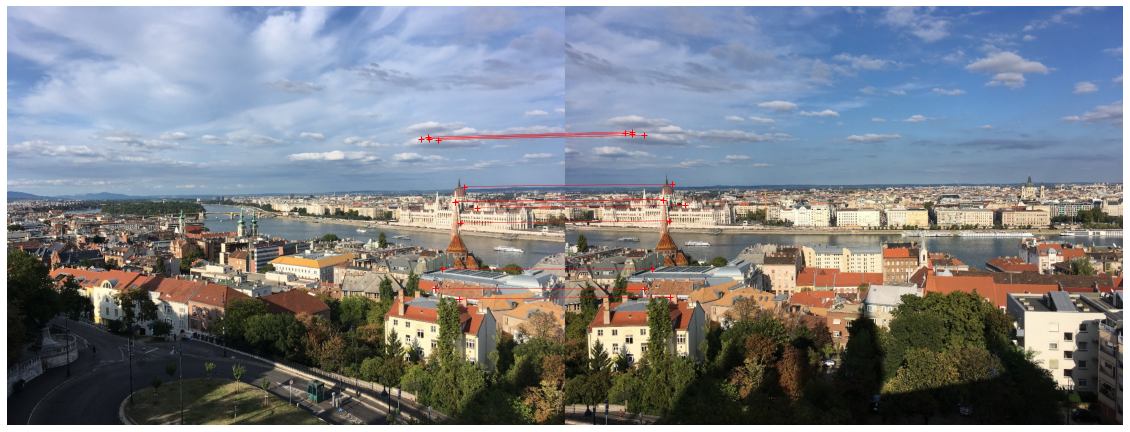

In [212]:
data = get_best_matches(img1, img2, 5000)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

num of inliners: 51 average residual: 111.33207252935841
num of inliers shown in the matching: 51


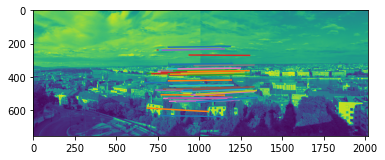

In [213]:
# display the inlier matching, report the average residual
# <YOUR CODE>
img1 = imread_bw('./stitch/left.jpg')
img2 = imread_bw('./stitch/right.jpg')
matches = get_best_matches(img1, img2, 10000)
data = ransac(img1, img2, matches, 110000)
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, data)
# fig.savefig('sift_match.pdf', bbox_inches='tight')
# print("Average residual:", np.average(best_model_errors))
# print("Inliers:", max_inliers)
# fig.savefig('ransac_match.pdf', bbox_inches='tight')

#### Part (5) warp images to stitch them together

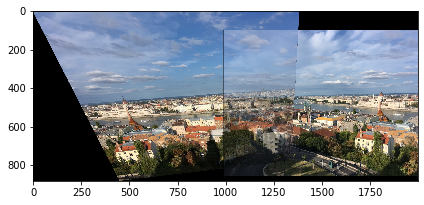

In [214]:
# display and report the stitching results
# <YOUR CODE>
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')
# img1 = imread_bw('./stitch/left.jpg')
# img2 = imread_bw('./stitch/right.jpg')
stitched_img = warp_images(img1, img2, data)
# cv2.imwrite('stitched_images.jpg', stitched_img[:,:,::-1]*255., [int(cv2.IMWRITE_JPEG_QUALITY), 90])
imshow(stitched_img)


In [215]:
def readimg(dirs, imgname):
    img = cv2.imread(dirs + imgname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def readimg_color(dirs, imgname):
    img = cv2.imread(dirs + imgname)
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return img

def main(leftimg, rightimg, leftimgcolor, rightimgcolor):
    # using 7000, 0.5 for 2 pic; 9000, 1.0 for 3 pic
    num_matches = 9000
    thres_ransac = 1.0

    kp1, dsp1 = get_sift_data(leftimg)
    kp2, dsp2 = get_sift_data(rightimg)

    # get all matching points
#     matches = get_best_matches(kp1, kp2, dsp1, dsp2, thres)
    matches =get_best_matches(leftimg, rightimg, num_matches)

    H_matrix = ransac(leftimg, rightimg, matches, thres_ransac)

    stitched_img = warp_images(rightimgcolor, leftimgcolor, H_matrix)

    return stitched_img

def main_2pic():
#     dirs = 'MP3_part1_data/' + 'park/'
    
#     leftimg = readimg(dirs, 'left.jpg')
#     rightimg = readimg(dirs, 'right.jpg')
#     leftimgcolor = readimg_color(dirs, 'left.jpg')
#     rightimgcolor = readimg_color(dirs, 'right.jpg')
#     leftimgcolor = imread('./stitch/left.jpg')
#     rightimgcolor = imread('./stitch/right.jpg')
#     leftimg = imread_bw('./stitch/left.jpg')
#     rightimg = imread_bw('./stitch/right.jpg')
    dirs = "./stitch/"
    leftimg = readimg(dirs, 'left.jpg')
    rightimg = readimg(dirs, 'right.jpg')
    leftimgcolor = readimg_color(dirs, 'left.jpg')
    rightimgcolor = readimg_color(dirs, 'right.jpg')

    stitched_img = main(leftimg, rightimg, leftimgcolor, rightimgcolor)

    plt.imshow(stitched_img)
    plt.show()

num of inliners: 39 average residual: 0.2749426435592204
num of inliers shown in the matching: 39


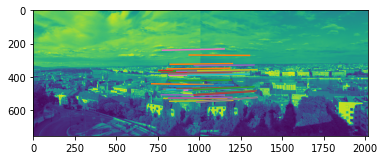

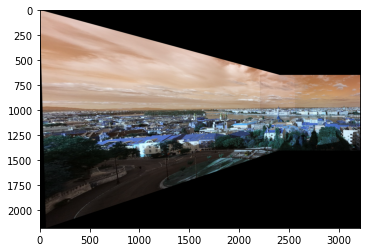

In [216]:
main_2pic()